In [1]:
import numpy as np
import pandas as pd
import onnxruntime as rt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
# Load the dataset
data = pd.read_csv('data/synth_data_for_training.csv')

y = data['checked']
X = data.drop(['checked'], axis=1)
X = X.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True, stratify=y)
# X_test = X 
# y_test = y

In [3]:
# Load the model
from concurrent.futures import ProcessPoolExecutor, as_completed
from multiprocessing import Manager

def get_predict_label_and_confidence(session, solution):
    y_pred_solution = session.run(None, {'X': solution.astype(np.float32)})

    # Predict checked or not checked
    label = y_pred_solution[0][0]
    
    # Only have two classes: checked and not checked
    confidence_top1_label = y_pred_solution[1][0][0]
    confidence_top2_label = y_pred_solution[1][0][1]
    
    return (label, confidence_top1_label, confidence_top2_label)


def get_mean_and_variance(feature):
    mean = feature.mean()
    variance = feature.var()
    
    return mean, variance


def get_fitness(y_true, y_pred): 
    # Get the predicted label and confidence
    label_original = y_true
    label_mutated, confidence_top1_label, confidence_top2_label = y_pred
    
    # If the prediction is different from the true label: fitness = - confidence_top1_label
    # If the prediction is the same as the true label: fitness = confidence_top1_label - confidence_top2_label    
    return -confidence_top1_label if label_mutated != label_original else confidence_top1_label - confidence_top2_label


def random_gaussian_mutation(solution, mutation_rate):
    mutated_solution = solution.copy()[0]
    num_features = len(mutated_solution)
    mutation_rate = np.random.randint(10, 50)/100
    num_mutations = max(1, int(mutation_rate * num_features))

    # Mutate a random subset of the features
    for _ in range(num_mutations):
        feature_index = np.random.randint(num_features)
        mean, variance = get_mean_and_variance(X_test[X_test.columns[feature_index]])
        mutation_value = np.random.normal(loc=mean, scale=np.sqrt(variance))
        mutated_solution[feature_index] += mutation_value if np.random.rand() < 0.5 else -mutation_value

    return mutated_solution.reshape(1, -1)


nFlips = {1: 0, 2: 0}
flippedIterations = {1: [], 2: []}

manager = Manager()
nFlips = manager.dict(nFlips)
flippedIterations = manager.dict(flippedIterations)

def stochastic_hill_climber(initial_solution, model, y_test_sample, num_iterations=10000, num_neighbors=10, mutation_rate=0.1):
    if model == 1:
        # new_session = rt.InferenceSession("../../Group3/model_1.onnx")
        session = rt.InferenceSession("model/model_1.onnx")    
    elif model == 2:
        # new_session = rt.InferenceSession("../../Group3/model_2.onnx")
        session = rt.InferenceSession("model/model_2.onnx")
    
    current_solution = initial_solution
    current_prediction = get_predict_label_and_confidence(session, current_solution)
    current_fitness = get_fitness(y_test_sample, current_prediction)
    
    counter = 0
    for i in range(num_iterations):
        neighbors = [random_gaussian_mutation(current_solution, mutation_rate) for _ in range(num_neighbors)]
        neighbor_scores = [get_fitness(y_test_sample, get_predict_label_and_confidence(session, neighbor)) for neighbor in neighbors]
        
        # Minimize the objective function
        best_neighbor_index = np.argmin(neighbor_scores)
        best_neighbor_score = neighbor_scores[best_neighbor_index]
        
        # Check if the best neighbor is better than the current solution
        if best_neighbor_score < current_fitness:
            current_solution = neighbors[best_neighbor_index]
            current_fitness = best_neighbor_score

            if current_prediction[0] != get_predict_label_and_confidence(session, current_solution)[0]:
                nFlips[model] += 1
                if counter == 0:
                    arr = flippedIterations[model]
                    arr.append(i+1)
                    flippedIterations[model] = arr
                    counter += 1

    return current_solution, current_fitness

best_solutions_scores_1 = []
best_solutions_scores_2 = []
global_best_score = None

# Get random samples from the test set
# subset_indices = np.random.choice(len(X_test), size=100, replace=False)
X_test_subset = X_test
y_test_subset = y_test

def task(X_test_sample, y_test_sample, model):
    # Take the first sample from the training set as the initial solution
    initial_solution = X_test_sample.reshape(1, -1)

    # Run the algorithm
    final_solution, best_score = stochastic_hill_climber(initial_solution, model, y_test_sample, num_iterations=10, num_neighbors=10, mutation_rate=0.2)

    return (X_test_sample, y_test_sample, final_solution, best_score)



tasks = []
for X_test_sample, y_test_sample in zip(X_test_subset.values, y_test_subset.values):
    tasks.append([task, X_test_sample, y_test_sample, 1])

with ProcessPoolExecutor() as executor:
    running_tasks = [executor.submit(
        task[0], task[1], task[2], task[3]) for task in tasks]
    for running_task in as_completed(running_tasks):
        best_solutions_scores_1.append(running_task.result())


# tasks = []
# for X_test_sample, y_test_sample in zip(X_test_subset.values, y_test_subset.values):
#     tasks.append([task, X_test_sample, y_test_sample, 2])

# with ProcessPoolExecutor() as executor:
#     running_tasks = [executor.submit(
#         task[0], task[1], task[2], task[3]) for task in tasks]
#     for running_task in as_completed(running_tasks):
#         best_solutions_scores_2.append(running_task.result())

In [4]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE


new_session = rt.InferenceSession("model/model_2.onnx")

data_biased = pd.concat([data, data[data['checked'] == 1]], axis=0)

y_train_biased = data_biased['checked']
X_train_biased = data_biased.drop(['checked'], axis=1)
X_train_biased = X_train_biased.astype(np.float32)

smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(
    X_train_biased, y_train_biased)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_smote, y_train_smote)

# Getting feature importances
feature_importances = clf.feature_importances_

# Converting feature importances into a more readable format
features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sorting features by importance
features_sorted = features.sort_values(by='Importance', ascending=False)

X_test_subset_feature_selected = X_test_subset[features_sorted.head(50)['Feature']]

tasks = []
for X_test_sample, y_test_sample in zip(X_test_subset_feature_selected.values, y_test_subset.values):
    tasks.append([task, X_test_sample, y_test_sample, 2])

with ProcessPoolExecutor() as executor:
    running_tasks = [executor.submit(
        task[0], task[1], task[2], task[3]) for task in tasks]
    for running_task in as_completed(running_tasks):
        best_solutions_scores_2.append(running_task.result())

In [5]:
from tabulate import tabulate

for i in [1, 2]:
    print(f"Model {i}")
    print(tabulate([[nFlips[i], 0 if len(flippedIterations[i]) == 0 else np.mean(flippedIterations[i]), 0 if len(flippedIterations[i]) == 0 else np.std(flippedIterations[i])]],
                                headers=["number of flips", "mean iterations to flip", "standard deviation iterations to flip"]))

Model 1
  number of flips    mean iterations to flip    standard deviation iterations to flip
-----------------  -------------------------  ---------------------------------------
            12159                    1.30467                                 0.492749
Model 2
  number of flips    mean iterations to flip    standard deviation iterations to flip
-----------------  -------------------------  ---------------------------------------
             8696                    1.13572                                 0.397557


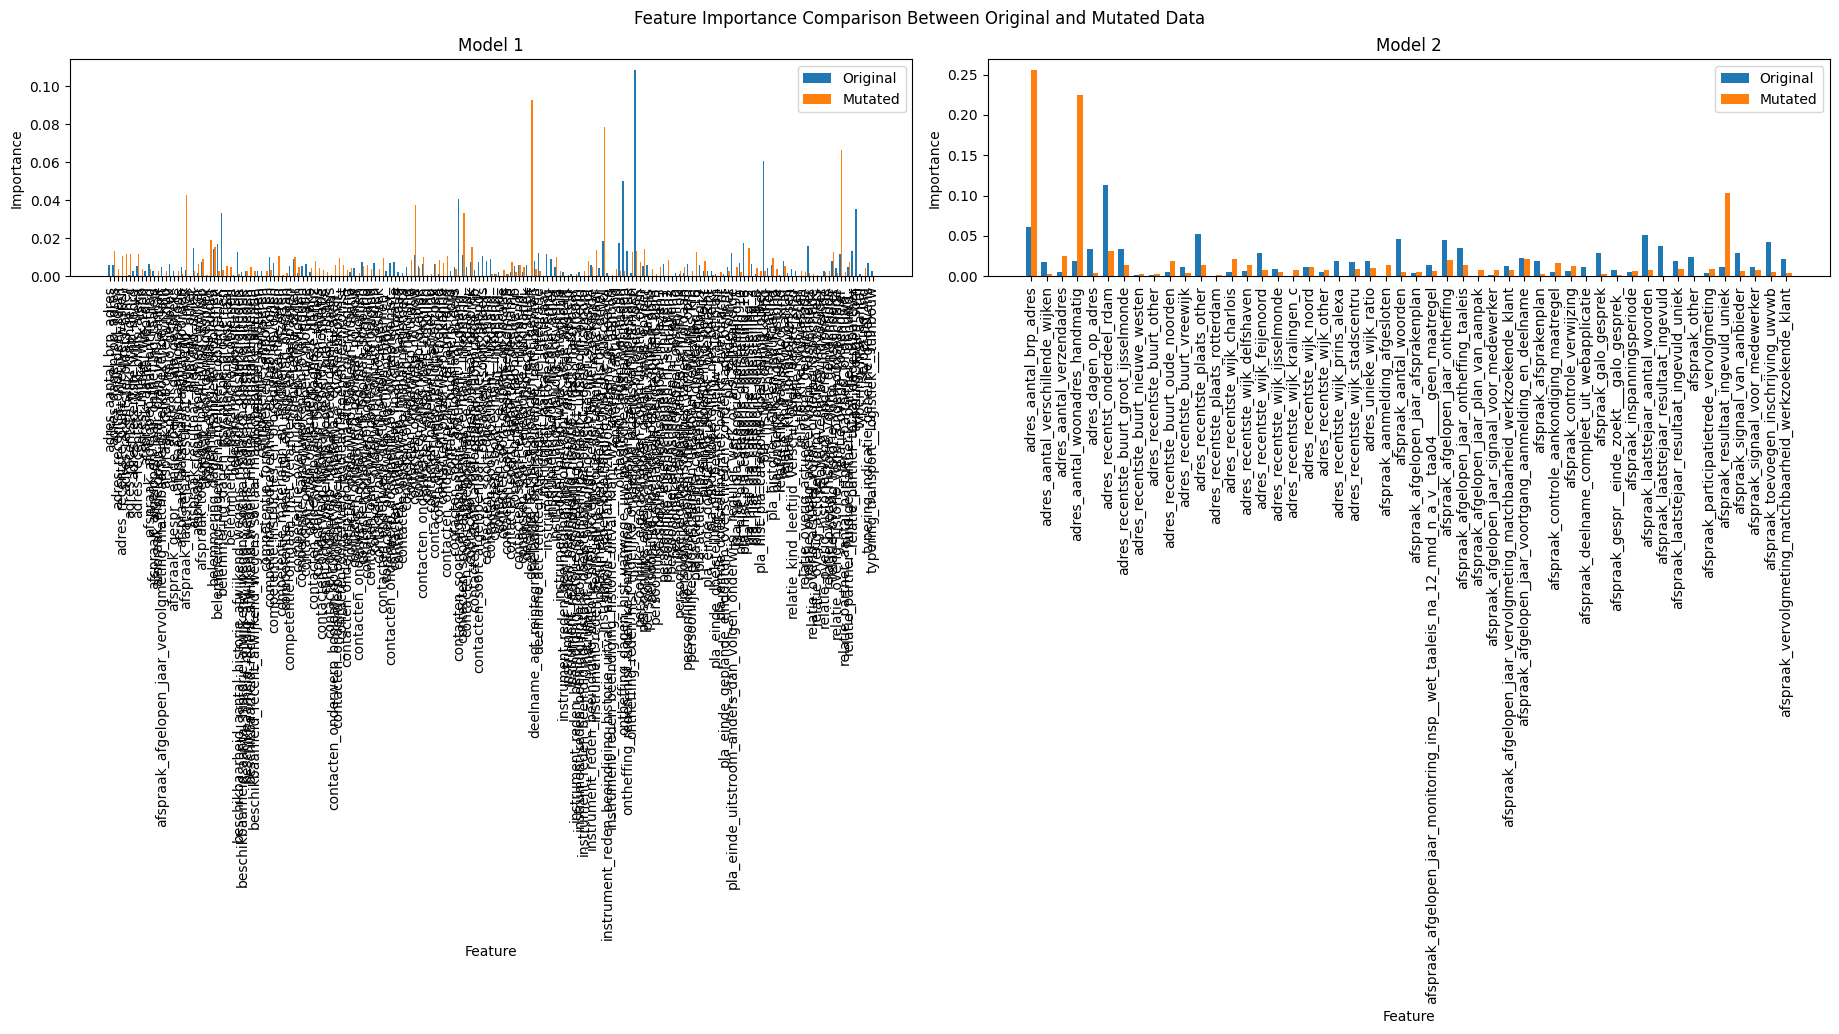

In [6]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)

for i, solutions in enumerate([best_solutions_scores_1, best_solutions_scores_2]):
    original_feature_importances = []
    mutated_feature_importances = []

    X_original, Y_labels, X_mutated, _ = zip(
        *[(x_sample, y_sample, solution[0], o_solution) for (x_sample, y_sample, solution, o_solution) in solutions])

    dt_original = DecisionTreeClassifier()
    dt_original.fit(X_original, Y_labels)
    original_feature_importances = dt_original.feature_importances_

    dt_mutated = DecisionTreeClassifier()
    dt_mutated.fit(X_mutated, Y_labels)
    mutated_feature_importances = dt_mutated.feature_importances_

    index = np.arange(len(original_feature_importances))
    bar_width = 0.35

    indices_to_delete = []

    for j in range(len(original_feature_importances) - 1, -1, -1):
        if original_feature_importances[j] == 0 and mutated_feature_importances[j] == 0:
            indices_to_delete.append(j)

    original_feature_importances = np.delete(
        original_feature_importances, indices_to_delete)
    mutated_feature_importances = np.delete(
        mutated_feature_importances, indices_to_delete)

    label_indices = np.delete(index, indices_to_delete)
    labels = X_test.columns[label_indices]

    index = np.arange(len(original_feature_importances))

    axs[i].bar(index, original_feature_importances, bar_width, label='Original')
    axs[i].bar(index + bar_width, mutated_feature_importances,
               bar_width, label='Mutated')
    axs[i].set_xlabel('Feature')
    axs[i].set_ylabel('Importance')
    axs[i].set_title(f'Model {i+1}')
    axs[i].set_xticks(index + bar_width / 2, labels, rotation=90)
    axs[i].legend()

fig.set_size_inches(18.5, 10.5)
fig.suptitle('Feature Importance Comparison Between Original and Mutated Data')
plt.tight_layout()

plt.show()

    

In [7]:
from tabulate import tabulate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    
    return accuracy, precision, recall, f1, roc_auc

# MODEL 1
# new_session = rt.InferenceSession("../../Group3/model_1.onnx")
new_session = rt.InferenceSession("model/model_1.onnx")

y_true = y_test.values
y_pred_original_1 = [get_predict_label_and_confidence(new_session, sample.reshape(1, -1))[0] for sample in X_test.values]

y_true_1_mutated = [y for _, y, _, _ in best_solutions_scores_1]
y_pred_1_mutated = [get_predict_label_and_confidence(new_session, solution)[0] for _, _, solution, _ in best_solutions_scores_1]

# MODEL 2
# new_session = rt.InferenceSession("../../Group3/model_2.onnx")
new_session = rt.InferenceSession("model/model_2.onnx")

y_pred_original_2 = [get_predict_label_and_confidence(
    new_session, sample.reshape(1, -1))[0] for sample in X_test_subset_feature_selected.values]

y_true_2_mutated = [y for _, y, _, _ in best_solutions_scores_2]
y_pred_2_mutated = [get_predict_label_and_confidence(
    new_session, solution)[0] for _, _, solution, _ in best_solutions_scores_2]


# Calculate metrics
metrics_original_1 = calculate_metrics(y_true, y_pred_original_1)
metrics_mutated_1 = calculate_metrics(y_true_1_mutated, y_pred_1_mutated)
metrics_original_2 = calculate_metrics(y_true, y_pred_original_2)
metrics_mutated_2 = calculate_metrics(y_true_2_mutated, y_pred_2_mutated)

# Metrics for two models
model_metrics_1 = [
    ("Original", {"accuracy": metrics_original_1[0],
     "precision": metrics_original_1[1], "recall": metrics_original_1[2], "f1": metrics_original_1[3], "roc_auc": metrics_original_1[4]}),
    ("Mutated", {"accuracy": metrics_mutated_1[0],
     "precision": metrics_mutated_1[1], "recall": metrics_mutated_1[2], "f1": metrics_mutated_1[3], "roc_auc": metrics_mutated_1[4]})
]

model_metrics_2 = [ 
    ("Original", {"accuracy": metrics_original_2[0],
        "precision": metrics_original_2[1], "recall": metrics_original_2[2], "f1": metrics_original_2[3], "roc_auc": metrics_original_2[4]}),
    ("Mutated", {"accuracy": metrics_mutated_2[0],
        "precision": metrics_mutated_2[1], "recall": metrics_mutated_2[2], "f1": metrics_mutated_2[3], "roc_auc": metrics_mutated_2[4]})
]

# Print the metrics

table_data_1 = [[model] + [metrics[metric] for metric in ["accuracy",
                                                        "precision", "recall", "f1", "roc_auc"]] for model, metrics in model_metrics_1]
table_data_2 = [[model] + [metrics[metric] for metric in ["accuracy",
                                                        "precision", "recall", "f1", "roc_auc"]] for model, metrics in model_metrics_2]

table_1_str = tabulate(table_data_1, headers=[
                       "Data", "Accuracy", "Precision", "Recall", "F1", "ROC"], tablefmt="grid")
table_2_str = tabulate(table_data_2, headers=[
                       "Data", "Accuracy", "Precision", "Recall", "F1", "ROC"], tablefmt="grid")

table_1_str_with_title = "Metrics model 1:\t\t\t\t\t\t\t\n" + table_1_str
table_2_str_with_title = "Metrics model 2:\n" + table_2_str

table_1_lines = table_1_str_with_title.split('\n')
table_2_lines = table_2_str_with_title.split('\n')

merged_lines = [f"{table_1_line}\t\t\t{table_2_line}" for table_1_line,
                table_2_line in zip(table_1_lines, table_2_lines)]

merged_table_str = '\n'.join(merged_lines)

print(merged_table_str)

# Print the confusion matrices
print("\n")

cm_original_1 = confusion_matrix(y_true, y_pred_original_1)
cm_mutated_1 = confusion_matrix(y_true_1_mutated, y_pred_1_mutated)

# Confusion matrices for model 2
cm_original_2 = confusion_matrix(y_true, y_pred_original_2)
cm_mutated_2 = confusion_matrix(y_true_2_mutated, y_pred_2_mutated)

# Constructing tables for confusion matrices
table_cm_original_model1 = [["Negative", cm_original_1[0][0], cm_original_1[0][1]],
                            ["Positive", cm_original_1[1][0], cm_original_1[1][1]]]

table_cm_mutated_model1 = [["Negative", cm_mutated_1[0][0], cm_mutated_1[0][1]],
                           ["Positive", cm_mutated_1[1][0], cm_mutated_1[1][1]]]

table_cm_original_model2 = [["Negative", cm_original_2[0][0], cm_original_2[0][1]],
                            ["Positive", cm_original_2[1][0], cm_original_2[1][1]]]

table_cm_mutated_model2 = [["Negative", cm_mutated_2[0][0], cm_mutated_2[0][1]],
                           ["Positive", cm_mutated_2[1][0], cm_mutated_2[1][1]]]

# Generating tabulated strings for confusion matrices
table_cm_original_model1_str = tabulate(table_cm_original_model1, headers=["Actual\\Predicted",
                                        "Negative", "Positive"], tablefmt="grid")
table_cm_mutated_model1_str = tabulate(table_cm_mutated_model1, headers=["Actual\\Predicted",
                                       "Negative", "Positive"], tablefmt="grid")
table_cm_original_model2_str = tabulate(table_cm_original_model2, headers=["Actual\\Predicted",
                                        "Negative", "Positive"], tablefmt="grid")
table_cm_mutated_model2_str = tabulate(table_cm_mutated_model2, headers=["Actual\\Predicted",
                                       "Negative", "Positive"], tablefmt="grid")

# Adding titles to the confusion matrices
table_cm_original_model1_str_with_title = "Model 1 Confusion matrix Original data:\n" + \
    table_cm_original_model1_str
table_cm_mutated_model1_str_with_title = "Model 1 Confusion matrix Mutated data:\n" + \
    table_cm_mutated_model1_str
table_cm_original_model2_str_with_title = "Model 2 Confusion matrix Original data:\n" + \
    table_cm_original_model2_str
table_cm_mutated_model2_str_with_title = "Model 2 Confusion matrix Mutated data:\n" + \
    table_cm_mutated_model2_str

# Splitting tabulated strings by newline character
table_cm_original_model1_lines = table_cm_original_model1_str_with_title.split(
    '\n')
table_cm_mutated_model1_lines = table_cm_mutated_model1_str_with_title.split(
    '\n')
table_cm_original_model2_lines = table_cm_original_model2_str_with_title.split(
    '\n')
table_cm_mutated_model2_lines = table_cm_mutated_model2_str_with_title.split(
    '\n')

# Merging corresponding lines from all tables
merged_cm_lines = [f"{cm_original_model1_line}\t\t{cm_mutated_model1_line}\t\t{cm_original_model2_line}\t\t{cm_mutated_model2_line}"
                   for cm_original_model1_line, cm_mutated_model1_line, cm_original_model2_line, cm_mutated_model2_line
                   in zip(table_cm_original_model1_lines, table_cm_mutated_model1_lines, table_cm_original_model2_lines, table_cm_mutated_model2_lines)]

# Joining merged lines back into a single string
merged_cm_table_str = '\n'.join(merged_cm_lines)

# Printing the merged confusion matrices
print(merged_cm_table_str)

# save the terminal output to a file
with open('stochastic_hill_climber_results_our_group_2.txt', 'w') as f:
    f.write(merged_table_str)
    f.write("\n")
    f.write(merged_cm_table_str)

Metrics model 1:										Metrics model 2:
+----------+------------+-------------+----------+----------+----------+			+----------+------------+-------------+----------+----------+----------+
| Data     |   Accuracy |   Precision |   Recall |       F1 |      ROC |			| Data     |   Accuracy |   Precision |   Recall |       F1 |      ROC |
+==========+============+=============+==========+==========+==========+			+==========+============+=============+==========+==========+==========+
| Original |  0.930153  |   0.801047  | 0.402632 | 0.535902 | 0.69575  |			| Original |  0.731154  |   0.209091  | 0.605263 | 0.310811 | 0.675215 |
+----------+------------+-------------+----------+----------+----------+			+----------+------------+-------------+----------+----------+----------+
| Mutated  |  0.0706378 |   0.0727865 | 0.705263 | 0.131955 | 0.352632 |			| Mutated  |  0.0788086 |   0.0805279 | 0.786842 | 0.146103 | 0.393421 |
+----------+------------+-------------+----------+----------+--------

In [8]:
model_1_sols = pd.DataFrame(columns=X_test.columns)
for _, y, solution, _ in best_solutions_scores_1:
    solution = pd.DataFrame(solution[0].reshape(1, -1), columns=X_test.columns)
    solution['checked'] = y
    model_1_sols = pd.concat([model_1_sols, solution])
model_1_sols.to_csv('stochastic_hill_climber_results_our_group_2_model_1.csv', index=False, header=True)

model_2_sols = pd.DataFrame(columns=X_test_subset_feature_selected.columns)
for _, y, solution, _ in best_solutions_scores_2:
    solution = pd.DataFrame(solution[0].reshape(1, -1), columns=X_test_subset_feature_selected.columns)
    solution['checked'] = y
    model_2_sols = pd.concat([model_2_sols, solution])
model_2_sols.to_csv(
    'stochastic_hill_climber_results_our_group_2_model_2.csv', index=False, header=True)

/tmp/ipykernel_6304/87182855.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_1_sols = pd.concat([model_1_sols, solution])
/tmp/ipykernel_6304/87182855.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_2_sols = pd.concat([model_2_sols, solution])


In [9]:
# print the average certainty of model 1 for the original and mutated data
new_session = rt.InferenceSession("model/model_1.onnx")

predictions_original_m1 = [get_predict_label_and_confidence(new_session, sample.reshape(1, -1))
                           for sample in X_test.values]

certainty_original_m1 = [certainty1 if label == 0 else certainty2 for label,
                         certainty1, certainty2 in predictions_original_m1]

predictions_mutated_m1 = [get_predict_label_and_confidence(
    new_session, solution) for _, _, solution, _ in best_solutions_scores_1]

certainty_mutated_m1 = [certainty1 if label == 0 else certainty2 for label,
                        certainty1, certainty2 in predictions_mutated_m1]

average_certainty_original_m1 = np.mean(certainty_original_m1)
average_certainty_mutated_m1 = np.mean(certainty_mutated_m1)

print(
    f"Average certainty model 1 original data: {average_certainty_original_m1}")
print(
    f"Average certainty model 1 mutated data: {average_certainty_mutated_m1}")

# print the average certainty of model 2 for the original and mutated data

new_session = rt.InferenceSession("model/model_2.onnx")

predictions_original_m2 = [get_predict_label_and_confidence(
    new_session, sample.reshape(1, -1)) for sample in X_test_subset_feature_selected.values]

certainty_original_m2 = [certainty1 if label == 0 else certainty2 for label,
                            certainty1, certainty2 in predictions_original_m2]

predictions_mutated_m2 = [get_predict_label_and_confidence(
    new_session, solution) for _, _, solution, _ in best_solutions_scores_2]

certainty_mutated_m2 = [certainty1 if label == 0 else certainty2 for label,
                        certainty1, certainty2 in predictions_mutated_m2]

average_certainty_original_m2 = np.mean(certainty_original_m2)
average_certainty_mutated_m2 = np.mean(certainty_mutated_m2)

print(
    f"Average certainty model 2 original data: {average_certainty_original_m2}")
print(        
    f"Average certainty model 2 mutated data: {average_certainty_mutated_m2}")

Average certainty model 1 original data: 0.9211929458565127
Average certainty model 1 mutated data: 0.5577942230196206
Average certainty model 2 original data: 0.8480501722114364
Average certainty model 2 mutated data: 0.5611823306438102
